# Tutorial for closure repository

Below the simple implementation of predicting electron heat flux is discussed, along with best guidelines. 
We will keep it simple in this exercise and only introduce the Multi Layer Peceptron (MLP) model and not apply any smoothing to the data.

We start by importing the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import src.trainers as tr
import importlib as imp
import numpy as np

## Trainer class

Trainer class is the main class that is used to train the model. It is responsible for loading the data, preprocessing it, training the model, and evaluating it. The class is defined in the `src/trainer.py` file. Before looking there you can play with few examples to get a feeling for it

The keyword arguments that it receives (kwargs) are split into dictionary which is broken into
* `work_dir`:         the directory where the results are saved
* `dataset_kwargs`:   keyword arguments that are passed to the dataset class. This prepares train, val and test datasets according to specifications
* `load_data_kwargs`: keyword arguments that are passed to the data loader. Data loader is in charge of sampling the data and creating the batches
* `model_kwargs`:     keyword arguments that are passed to the model class, including optimizers and architectures

### Dataset class

It helps if you have already looked at `examples/read_PIC.ipynb` to understand how to read data. The parameters we will require there are:

In [2]:
read_features_targets_kwargs = {'fields_to_read' :    {"B": True,"B_ext": False,"divB": False,"E": True,"E_ext": False,"rho": True,"J": True,
                                                      "P": True,"PI": True,"Heat_flux": False,"N": False,"Qrem": False}, # which fields to read
                                'request_features' :  ['rho_e', 'Bx', 'By', 'Bz', 'Vx_e', 'Vy_e', 'Vz_e', 'Ex', 'Ey', 'Ez'],  # what network needs to make predictions
                                'request_targets' :   ["Pxx_e", "Pyy_e","Pzz_e","Pxy_e","Pxz_e","Pyz_e"],                     # what we want to predict
                                'choose_species' :    ['e',None],   # which species to take
                                'choose_x' : [0,256], 'choose_y' : [0,256], 'verbose' : False  # which part of the domain to take. The full domain is 2048x2048 and is too heavy for the tutorial
                          } # make sure not to put a comma here, otherwise the object becomes a tuple rather than a dictionary which causes all sorts of problems

Now we construct the full dataset_kwargs dictionary which contains the following with the comments that explain each key:

In [3]:
dataset_kwargs = {'data_folder': "/lustre1/project/stg_00032/share_dir/",               # where the data is stored
                          'image_file_name_column' : 'filenames',                       # the column in the csv file that contains the image file names
                          'read_features_targets_kwargs' : read_features_targets_kwargs,
                          'train_sample' :  "/lustre1/project/stg_00032/share_dir/brecht/sampling/turbulence/train.csv",  # this should be the path to the csv file that contains a list of training samples, each cell corresponds to local paths to the actual data relative to `data_folder`
                          'val_sample' :    "/lustre1/project/stg_00032/share_dir/brecht/sampling/turbulence/val.csv",    # same but validation
                          'test_sample' :   "/lustre1/project/stg_00032/share_dir/brecht/sampling/turbulence/test.csv",   # same but testing
                          'scaler_features' : True,    # Whether to normalize the features. It is called scaler because it rescales to 0 mean and 1 variance
                          'scaler_targets' : True,     # Whether to normalize the targets
                          'prescaler_targets' : ['log','log','log',None,None,None]  # If we want to transform the targets before training. The order in which they appear correspond to `request_targets` in `read_features_targets_kwargs``
                      }

To see what snapshots are taken as test sample

In [4]:
import pandas as pd
pd.read_csv(dataset_kwargs['test_sample'])

filenames
0  peppe/data/MSH-Fields_006000.h5
1  peppe/data/MSH-Fields_006500.h5
2  peppe/data/MSH-Fields_007000.h5
3  peppe/data/MSH-Fields_007500.h5
4  peppe/data/MSH-Fields_014000.h5
5  peppe/data/MSH-Fields_014500.h5
6  peppe/data/MSH-Fields_015000.h5

The next step is to define `load_data_kwargs` which we feed to the data loader. 

Since the model we are using below works locally, the data is flattened automatically so that each cell in space and time is individual sample. This is done after splitting the data into train, validation and test sets. Because each cell is now a sample, we may choose to undersample the data to reduce the size of the dataset. This is done by setting the `subsample_rate` key in the `load_data_kwargs` dictionary. So as a result we will work with less data and the training will be faster. Of course, if we want to get best results we should use all the data.

In [5]:
load_data_kwargs={'train_loader_kwargs' : {'batch_size' : 512,      #training batch size
                                           'subsample_rate' : .2,   #subsample rate which defines a fraction of data that is used when sampling. 1 means all data is used
                                           'subsample_seed' : 42,   #seed for the subsampling
                                           'seed' : 42,             #seed for the random number generator
                                           'shuffle' : True},       #shuffle the training set
                    'val_loader_kwargs' : {'batch_size' : 512,        #validation batch size
                                           'subsample_rate' : .2, 
                                           'subsample_seed' : 42, 
                                           'shuffle' : False}}      # we don't need to shuffle the validation set

We are using Multi Layer Perceptron with 4 hidden layers and mostly `Tanh` activation functions. `ReduceLROnPlateau` scheduler is used, which essentially monitors 
validation loss and reduces learning rate if the loss does not decrease for a certain number of epochs. Notice that `early_stopping` may interfere with this policy

In [6]:
model_kwargs={'model': 'MLP',    # the model class name we want to use, check `src/models.py` for available models
              'model_seed' : 42, # seed for the random initialization of the model
              'feature_dims' : [10, 60, 80, 50, 40, 6], # the dimensions of the layers in the model. The first element should be the number of `request_features` in `read_features_targets_kwargs` and the last element should be the number of `request_targets` in `read_features_targets_kwargs`
              'activations' : ['Tanh','Tanh','ReLU','Tanh', None], 
    'optimizer_kwargs': {'optimizer' : 'Adam',      # look up https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#adam 
                         'lr' : 5e-4,               # learning rate
                         'criterion': 'MSELoss'},   # the loss function to optimize
    'scheduler_kwargs': {'scheduler' : 'ReduceLROnPlateau',  # look up https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
                         'mode' : 'min',  # the remainder are the arguments for the ReduceLROnPlateau scheduler
                         'factor' : 0.2, 
                         'patience' : 10, 
                         'cooldown' : 15 , 
                         'epochs' : 10,                 # number of epochs before stoppig training
                         'early_stopping' : 20},        # number of epochs to tolarate without 
    'logger_kwargs':{'update_step': 1, 'show': True}}   # some details about how to log the training process

The lines below will create the Trainer object and train the model. The Trainer object will load the data from the original h5 files, convert it first to numpy, preprocess it and convert to torch tensors. The outputs will be saved in the `work_dir` directory.

This is the first time that we initalize the model and the enclosing directory so everything will be created from scratch. This operation may take a while, depending on the size of the dataset. In the future we will introduce the possibility of saving all the steps performed by datasets class and save it to a pickle file. 

In [7]:
work_dir = '/lustre1/project/stg_00032/georgem/closure/models/dev/dev16/'  # you may have to create containing path before running the script (check in the source code). It is better to use absolute paths than relative paths for the operations below to work
                                                                            # the /dev16/ folder on the other hand will be definitely created by the trainer so you don't need to create it
! rm -rf {work_dir}  # This will delete the previously existing model
trainer = tr.Trainer(work_dir=work_dir,   # where the model will be saved
                     dataset_kwargs=dataset_kwargs, load_data_kwargs=load_data_kwargs, model_kwargs=model_kwargs)

INFO:src.trainers:Creating a new configuration file: /lustre1/project/stg_00032/georgem/closure/models/dev/dev16/config.json
INFO:src.trainers: 
INFO:src.trainers:========Logging to /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//training.log on level 20===========
INFO:src.trainers:host: r25i13n04
INFO:src.trainers: 
INFO:src.datasets: This is train set
INFO:src.datasets:Datasplit performed according to /lustre1/project/stg_00032/share_dir/brecht/sampling/turbulence/train.csv
INFO:src.datasets:Features shape: (1048576, 10), Targets shape: (1048576, 6)
INFO:src.datasets:Saved self.features_mean, self.features_std to /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//X.pkl
INFO:src.datasets:Normalization applied to features
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Saved self.targets_mean, self.targets_st

Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

Above the code returns the operations and the specific python files used to run the scripts. 

Other useful information can be found there. We can see what model was initialized, where the files are sourced and the shape of the data

As can be seen now the work directory will contain the following files, including 
* the configuration file which inherits the inputs to the trainer class
* training log that you see above with timed outputs
* normalization parameters that are used to normalize the data:

In [8]:
! ls {work_dir}

config.json  training.log  X.pkl  y.pkl


In this notebook we are building up to creation of the `config.json` file, so we do it by running the training class. In the future you will see that all that you need is a `config.json` file.

What has been created is a trainer class instance, equipped with the loaders and processed datasets that received configurations that we specified above:

In [9]:
print(f"trainer work dir: \t\t{trainer.work_dir}")
print(f"trainer class instance: \t{trainer}")
print(f"trainer loader: \t\t{trainer.train_loader}")
print(f"train dataset features shape: \t {trainer.train_dataset.features.shape}")
print(f"train dataset targets shape: \t{trainer.train_dataset.targets.shape}")

trainer work dir: 		/lustre1/project/stg_00032/georgem/closure/models/dev/dev16/
trainer class instance: 	<src.trainers.Trainer object at 0x7fdd3027e8c0>
trainer loader: 		<src.datasets.ChannelDataLoader object at 0x7fdc52028160>
train dataset features shape: 	 torch.Size([1048576, 10])
train dataset targets shape: 	torch.Size([1048576, 6])


Now we are ready to train, since we already have the trainer class in RAM. Notice that the performance will depend on the type of CPU/GPU you are using

In [10]:
trainer.fit()

INFO:src.trainers:Prior to fit: RAM memory % used: 12.1, RAM Used (GB):, 23.038595072, process RAM usage (GB): 0.715911865234375


Epoch 1/10 | Train loss: {'criterion': 0.12649757306023343} | Validation loss: {'criterion': 2.5204542485679067} | Time/epoch: 3.7987 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 1/10 | Train loss: {'criterion': 0.12649757306023343} | Validation loss: {'criterion': 2.5204542485679067} | Time/epoch: 3.7987 seconds | Learning rate: [0.0005]


Epoch 2/10 | Train loss: {'criterion': 0.027318828689252457} | Validation loss: {'criterion': 2.3761220431909327} | Time/epoch: 3.69345 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 2/10 | Train loss: {'criterion': 0.027318828689252457} | Validation loss: {'criterion': 2.3761220431909327} | Time/epoch: 3.69345 seconds | Learning rate: [0.0005]


Epoch 3/10 | Train loss: {'criterion': 0.020146741504531083} | Validation loss: {'criterion': 2.1542177822531725} | Time/epoch: 3.43885 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 3/10 | Train loss: {'criterion': 0.020146741504531083} | Validation loss: {'criterion': 2.1542177822531725} | Time/epoch: 3.43885 seconds | Learning rate: [0.0005]


Epoch 4/10 | Train loss: {'criterion': 0.018034537927043147} | Validation loss: {'criterion': 2.063298889485801} | Time/epoch: 3.66849 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 4/10 | Train loss: {'criterion': 0.018034537927043147} | Validation loss: {'criterion': 2.063298889485801} | Time/epoch: 3.66849 seconds | Learning rate: [0.0005]


Epoch 5/10 | Train loss: {'criterion': 0.01689576365553388} | Validation loss: {'criterion': 2.024892813403432} | Time/epoch: 3.48602 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 5/10 | Train loss: {'criterion': 0.01689576365553388} | Validation loss: {'criterion': 2.024892813403432} | Time/epoch: 3.48602 seconds | Learning rate: [0.0005]


Epoch 6/10 | Train loss: {'criterion': 0.016183112280034436} | Validation loss: {'criterion': 1.9761648579341609} | Time/epoch: 3.56185 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 6/10 | Train loss: {'criterion': 0.016183112280034436} | Validation loss: {'criterion': 1.9761648579341609} | Time/epoch: 3.56185 seconds | Learning rate: [0.0005]


Epoch 7/10 | Train loss: {'criterion': 0.015775518991598268} | Validation loss: {'criterion': 1.9540603713291447} | Time/epoch: 3.65253 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 7/10 | Train loss: {'criterion': 0.015775518991598268} | Validation loss: {'criterion': 1.9540603713291447} | Time/epoch: 3.65253 seconds | Learning rate: [0.0005]


Epoch 8/10 | Train loss: {'criterion': 0.01547020143806571} | Validation loss: {'criterion': 1.9296743846521145} | Time/epoch: 3.75527 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 8/10 | Train loss: {'criterion': 0.01547020143806571} | Validation loss: {'criterion': 1.9296743846521145} | Time/epoch: 3.75527 seconds | Learning rate: [0.0005]


Epoch 9/10 | Train loss: {'criterion': 0.015186686650282} | Validation loss: {'criterion': 1.9054668002012298} | Time/epoch: 3.68751 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 9/10 | Train loss: {'criterion': 0.015186686650282} | Validation loss: {'criterion': 1.9054668002012298} | Time/epoch: 3.68751 seconds | Learning rate: [0.0005]


Epoch 10/10 | Train loss: {'criterion': 0.014997081781124197} | Validation loss: {'criterion': 1.8880122469692695} | Time/epoch: 3.56356 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 10/10 | Train loss: {'criterion': 0.014997081781124197} | Validation loss: {'criterion': 1.8880122469692695} | Time/epoch: 3.56356 seconds | Learning rate: [0.0005]


Best loss: 1.8880122469692695 at epoch 10, restoring the corresponding weights...


INFO:src.models:Best loss: 1.8880122469692695 at epoch 10, restoring the corresponding weights...


End of training. Total time: 36.33797 seconds


INFO:src.models:End of training. Total time: 36.33797 seconds
INFO:src.trainers:After fit: RAM memory % used: 12.1, RAM Used (GB):, 22.99625472, process RAM usage (GB): 0.737274169921875
INFO:src.trainers:Saving the model weights and loss history to /lustre1/project/stg_00032/georgem/closure/models/dev/dev16///


1.8880122469692695

At this point we have not converged yet, but we can see that the loss is decreasing. 

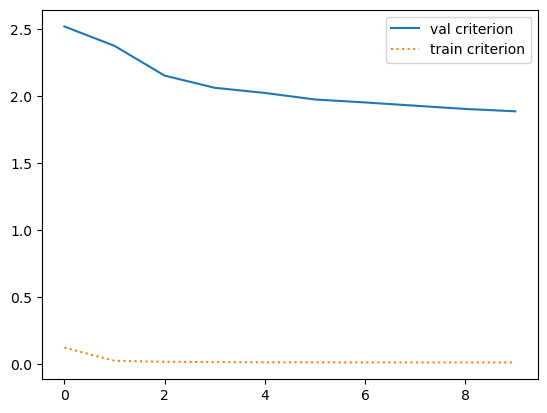

In [11]:
import matplotlib.pyplot as plt
for key, val_loss in trainer.model.val_loss_.items():
    plt.plot(val_loss, label=f'val {key}')
for key, val_loss in trainer.model.train_loss_.items():
    plt.plot(val_loss, label=f'train {key}', linestyle=':')
#plt.ylim(0, 8e-1)
plt.legend()
plt.show()

### Multiple runs in the same trainer folder

We see a severe case of overfitting since, while both training and validation losses are decreasing, the loss on the validation set is several orders of magnitude higher than the training loss. This model is not expected to work well. The most likely explanation for this is lack of data in this case.

Thus, it makes sense to try using at least all the data that was in the 256x256 portion of the images. In other words, we should set `subsample_rate` to 1.0.

In [12]:
load_data_kwargs={'train_loader_kwargs' : {'batch_size' : 512,      #training batch size
                                           'subsample_rate' : 1,   #subsample rate which defines a fraction of data that is used when sampling. 1 means all data is used
                                           'subsample_seed' : 42,   #seed for the subsampling
                                           'seed' : 42,             #seed for the random number generator
                                           'shuffle' : True},       #shuffle the training set
                    'val_loader_kwargs' : {'batch_size' : 512,        #validation batch size
                                           'subsample_rate' : 1, 
                                           'subsample_seed' : 42, 
                                           'shuffle' : False}}      # we don't need to shuffle the validation set

Now it is time to introduce how to run multiple runs in the same trainer folder. This is useful when you want to compare different models or hyperparameters. This operation is possible as long as you don't change the input data. If you change the dataset, you should create a new trainer in a separate folder to avoid issues associated with normalization that would be not consistent with the previous runs (the ones stored in `X.pkl` and `y.pkl` files).

Essentially, to make new runs you need to take previous config file and change the parameters you want to change. In this case we are changing data loader. This is very convenient when doing parametric studies, optimizing parameters such as learning rate, batch size, number of layers, etc. This can also be done automatically with Bayesian parameter optimizers, such as Optuna. 

In [13]:
import copy  # because configurations are a dictionary we must use deepcopy to avoid changing the original configuration
config = copy.deepcopy(trainer.config)
config['run'] = 'nosubsample'
config['load_data_kwargs'] = load_data_kwargs

Since we are working with more data you should expect the training to take longer.  

In [14]:
trainer.fit(config=config)

Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

Epoch 1/10 | Train loss: {'criterion': 0.19334657557556056} | Validation loss: {'criterion': 0.6450187056907453} | Time/epoch: 18.06174 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 1/10 | Train loss: {'criterion': 0.19334657557556056} | Validation loss: {'criterion': 0.6450187056907453} | Time/epoch: 18.06174 seconds | Learning rate: [0.0005]


Epoch 2/10 | Train loss: {'criterion': 0.08929610230916296} | Validation loss: {'criterion': 0.6110371724062134} | Time/epoch: 18.00618 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 2/10 | Train loss: {'criterion': 0.08929610230916296} | Validation loss: {'criterion': 0.6110371724062134} | Time/epoch: 18.00618 seconds | Learning rate: [0.0005]


Epoch 3/10 | Train loss: {'criterion': 0.07510275545791956} | Validation loss: {'criterion': 0.6160265048674773} | Time/epoch: 18.11626 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 3/10 | Train loss: {'criterion': 0.07510275545791956} | Validation loss: {'criterion': 0.6160265048674773} | Time/epoch: 18.11626 seconds | Learning rate: [0.0005]


Epoch 4/10 | Train loss: {'criterion': 0.06756003607551975} | Validation loss: {'criterion': 0.6057656712946482} | Time/epoch: 17.72491 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 4/10 | Train loss: {'criterion': 0.06756003607551975} | Validation loss: {'criterion': 0.6057656712946482} | Time/epoch: 17.72491 seconds | Learning rate: [0.0005]


Epoch 5/10 | Train loss: {'criterion': 0.0625081166945165} | Validation loss: {'criterion': 0.6276482400426175} | Time/epoch: 17.64842 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 5/10 | Train loss: {'criterion': 0.0625081166945165} | Validation loss: {'criterion': 0.6276482400426175} | Time/epoch: 17.64842 seconds | Learning rate: [0.0005]


Epoch 6/10 | Train loss: {'criterion': 0.05892708993087581} | Validation loss: {'criterion': 0.6352696359390393} | Time/epoch: 17.46561 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 6/10 | Train loss: {'criterion': 0.05892708993087581} | Validation loss: {'criterion': 0.6352696359390393} | Time/epoch: 17.46561 seconds | Learning rate: [0.0005]


Epoch 7/10 | Train loss: {'criterion': 0.056284035425051115} | Validation loss: {'criterion': 0.6344081755087245} | Time/epoch: 18.23093 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 7/10 | Train loss: {'criterion': 0.056284035425051115} | Validation loss: {'criterion': 0.6344081755087245} | Time/epoch: 18.23093 seconds | Learning rate: [0.0005]


Epoch 8/10 | Train loss: {'criterion': 0.05425758531782776} | Validation loss: {'criterion': 0.6232576067559421} | Time/epoch: 17.31707 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 8/10 | Train loss: {'criterion': 0.05425758531782776} | Validation loss: {'criterion': 0.6232576067559421} | Time/epoch: 17.31707 seconds | Learning rate: [0.0005]


Epoch 9/10 | Train loss: {'criterion': 0.05253639683360234} | Validation loss: {'criterion': 0.6300081917434} | Time/epoch: 17.90029 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 9/10 | Train loss: {'criterion': 0.05253639683360234} | Validation loss: {'criterion': 0.6300081917434} | Time/epoch: 17.90029 seconds | Learning rate: [0.0005]


Epoch 10/10 | Train loss: {'criterion': 0.05126999759704631} | Validation loss: {'criterion': 0.6446448642527685} | Time/epoch: 17.97107 seconds | Learning rate: [0.0005]


INFO:src.models:Epoch 10/10 | Train loss: {'criterion': 0.05126999759704631} | Validation loss: {'criterion': 0.6446448642527685} | Time/epoch: 17.97107 seconds | Learning rate: [0.0005]


Best loss: 0.6057656712946482 at epoch 4, restoring the corresponding weights...


INFO:src.models:Best loss: 0.6057656712946482 at epoch 4, restoring the corresponding weights...


End of training. Total time: 178.47279 seconds


INFO:src.models:End of training. Total time: 178.47279 seconds
INFO:src.trainers:After fit: RAM memory % used: 11.6, RAM Used (GB):, 21.952856064, process RAM usage (GB): 0.7547035217285156
INFO:src.trainers:Saving the model weights and loss history to /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//nosubsample/


0.6057656712946482

Notice that now there is a new sub-folder that was created:

In [15]:
! ls {work_dir}
! ls {work_dir}/nosubsample # the sub-folder contains the corresponding model, its own configuration and the training logs (run.log) specific to this run. The loss history is stored in loss_dict.pkl

config.json  loss_dict.pkl  model.pth  nosubsample  training.log  X.pkl  y.pkl
config.json  loss_dict.pkl  model.pth  run.log


In [19]:
print(f"work directory: {trainer.work_dir}")
print(f"{trainer.run = }")

work directory: /lustre1/project/stg_00032/georgem/closure/models/dev/dev16/
trainer.run = 'nosubsample'


The model we get as a result still overfits but at least we can do the first tests

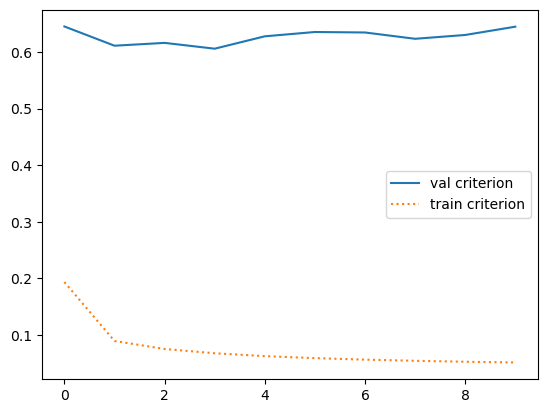

In [20]:
import matplotlib.pyplot as plt
for key, val_loss in trainer.model.val_loss_.items():
    plt.plot(val_loss, label=f'val {key}')
for key, val_loss in trainer.model.train_loss_.items():
    plt.plot(val_loss, label=f'train {key}', linestyle=':')
#plt.ylim(0, 8e-1)
plt.legend()
plt.show()

### Evaluation of the model

Evaluation of the model can be made based on the test loss which can be computed after predicting the targets on the test set. This is achieved by calling `pred_ground_targets`

In [21]:
prediction, ground_truth, list_of_target_indices = tr.ut.pred_ground_targets(trainer)

The function pred_ground_targets is deprecated. Use transform_targets instead.
Total loss 0.594347357749939
Loss for channel 0:  Pxx_e, loss = 0.12743356823921204
Loss for channel 1:  Pyy_e, loss = 0.142177551984787
Loss for channel 2:  Pzz_e, loss = 0.1560910940170288
Loss for channel 3:  Pxy_e, loss = 1.1100741624832153
Loss for channel 4:  Pxz_e, loss = 1.3478821516036987
Loss for channel 5:  Pyz_e, loss = 0.6824254393577576


We see that performance on the off-diagonal elements is much worse than on the diagonal elements

Important thing to note is that the outputs of this function are still in the form of the normalized scaled data that the neural network was using. So to correctly interpret they have to be re-scaled properly. Fortunately there is a plotting function that has already been written for this purpose.

The function pred_ground_targets is deprecated. Use graph_pred_targets instead.
invfunc = <ufunc 'exp'>


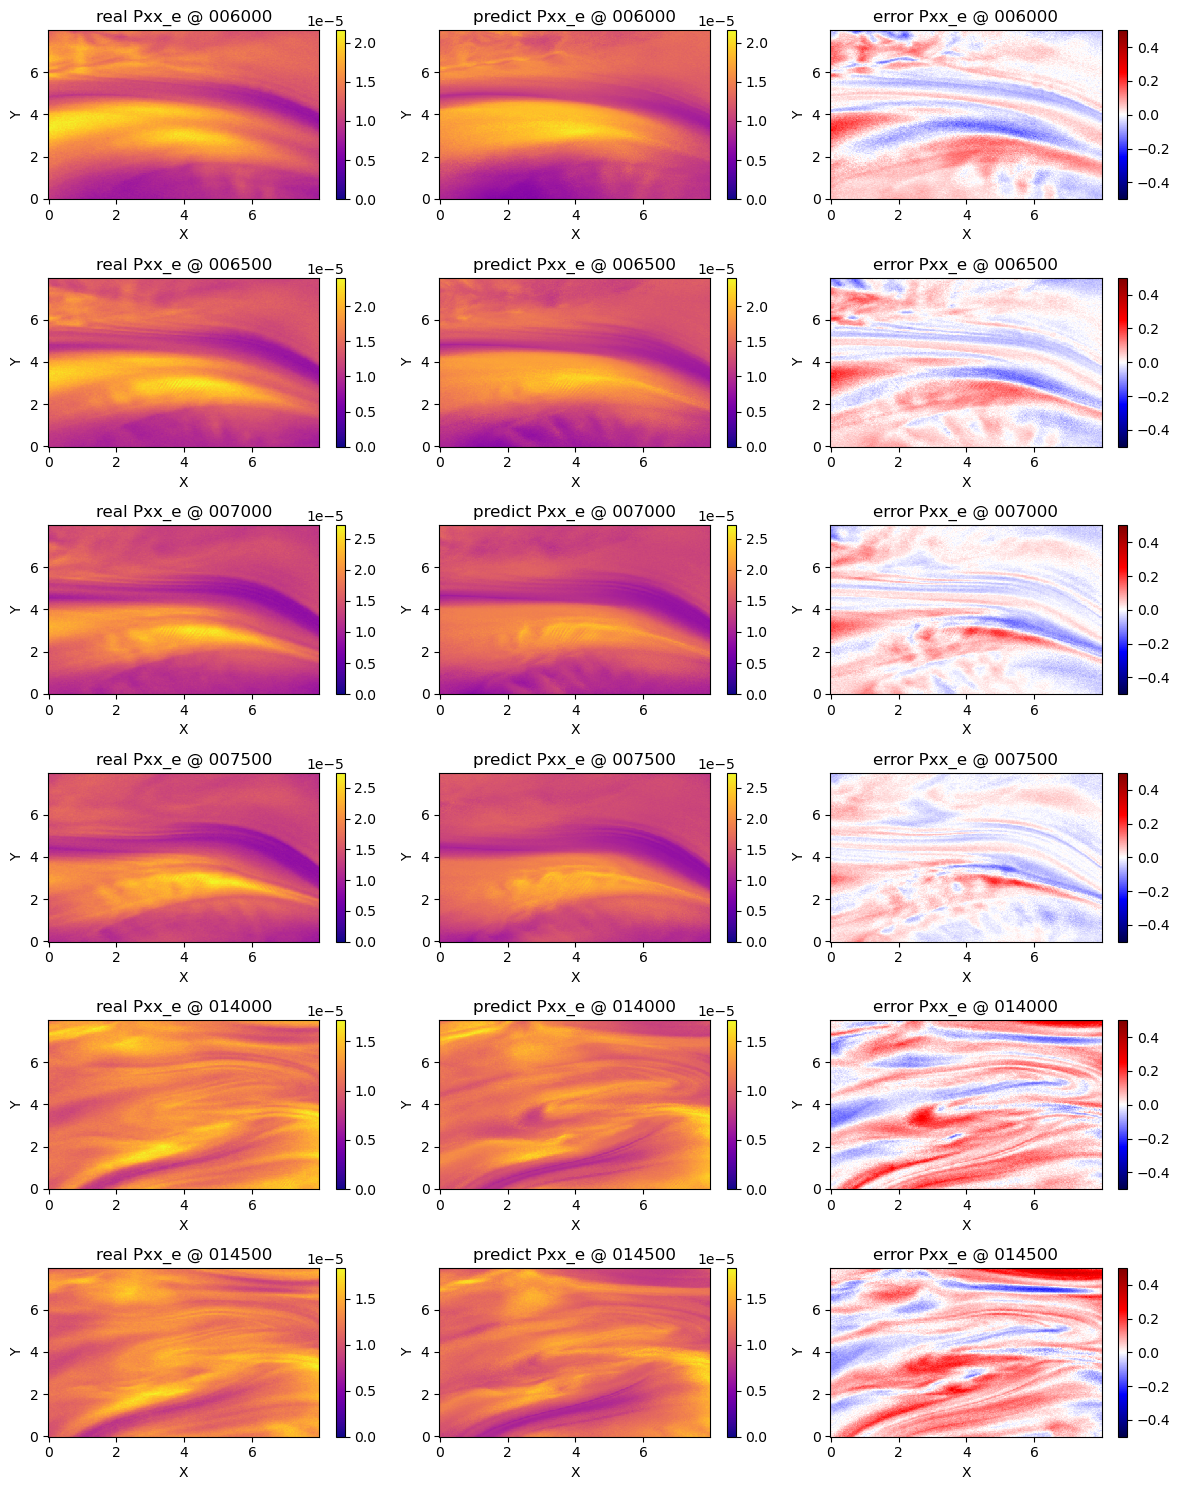

In [22]:
tr.ut.plot_pred_targets(trainer, 'Pxx_e', prediction, ground_truth, list_of_target_indices, figsize=(12,15))

We see that some large scale structures are sort-of predicted ok, but the details are not, especially in fully-developed case. To get better feeling for how `plot_pred_targets` works please see the source code

The function pred_ground_targets is deprecated. Use graph_pred_targets instead.
invfunc = <function plot_pred_targets.<locals>.<lambda> at 0x7fdc4b6b7ac0>


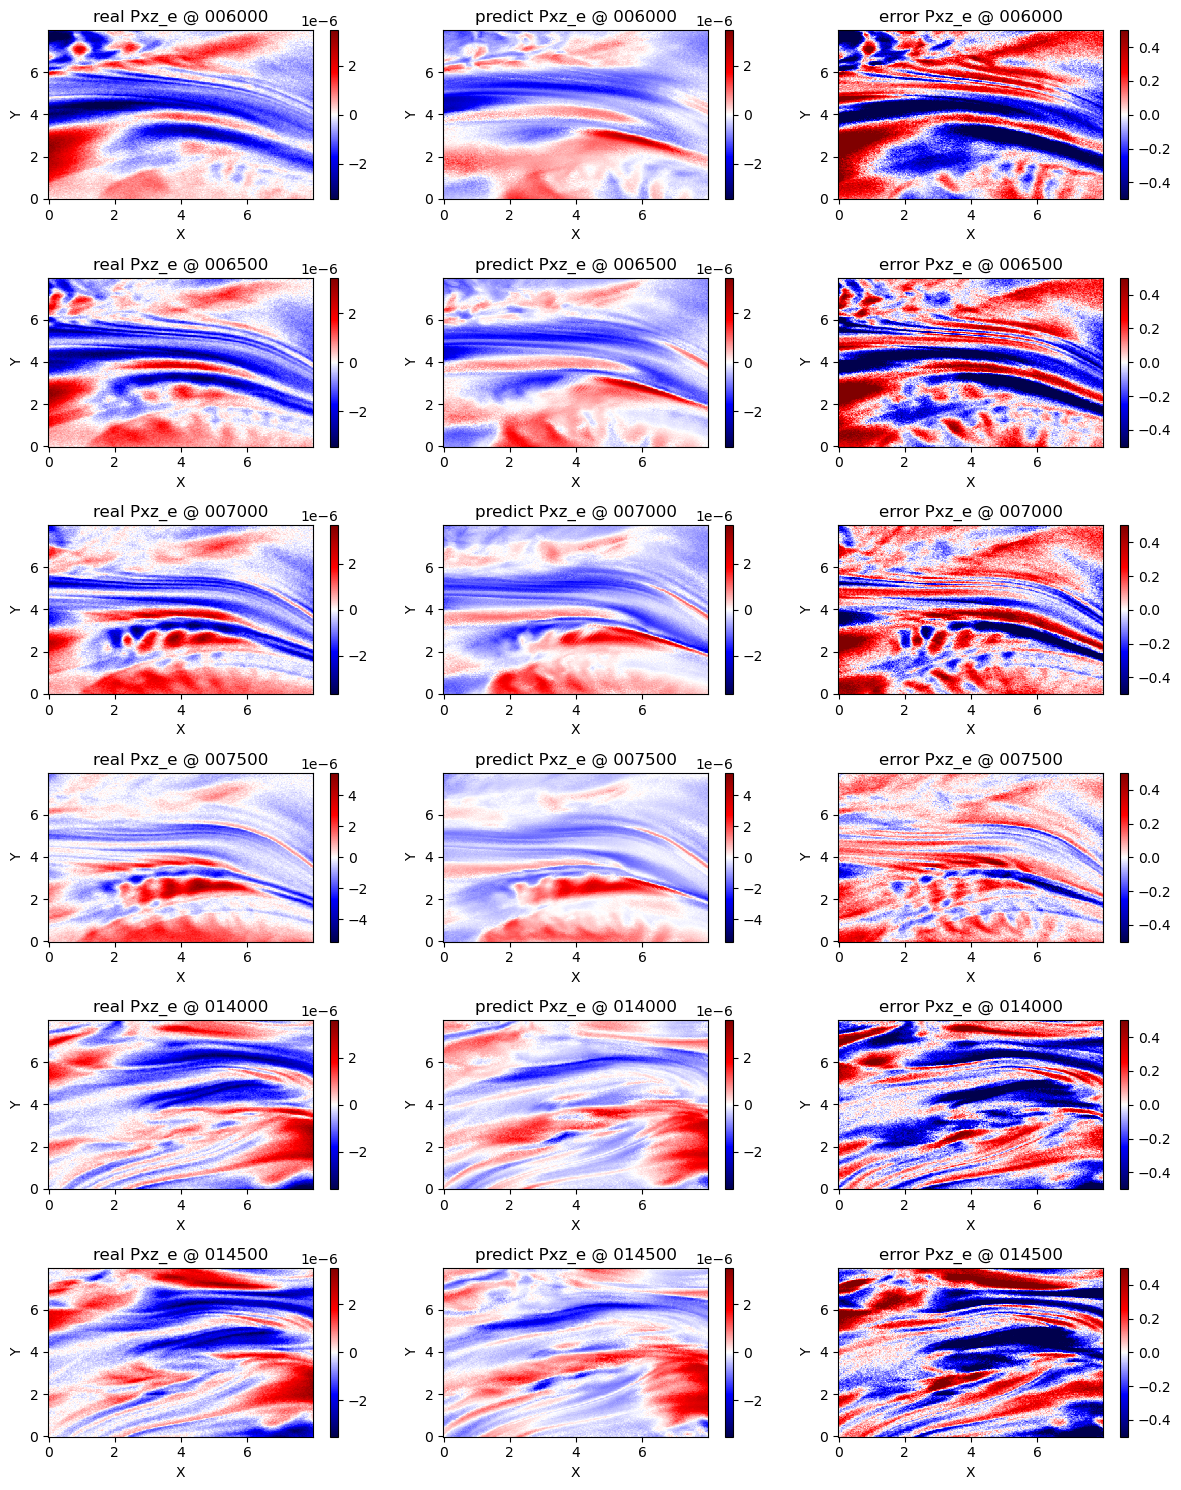

In [23]:
tr.ut.plot_pred_targets(trainer, 'Pxz_e', prediction, ground_truth, list_of_target_indices, figsize=(12,15))

Indeed, the off-diagonal elements are not predicted well. The question about which data to use as training is an important one

## Reloading previous runs
Trainer class is equipped with a function that allows re-loading the specific model in use. At the moment we have two networks, one in the parent folder (which we do not recommend in future) and one in the sub-folder. We will load the model from the parent folder

In [45]:
import os

last_part = os.path.basename(work_dir.rstrip('/'))
print(last_part)


dev16


In [47]:
trainer.work_dir

'/lustre1/project/stg_00032/georgem/closure/models/dev/dev16/'

In [24]:
trainer.load_run(f"./") # load the run which is in the parent directory (runs are always defined relative to the work_dir)

INFO:src.trainers: 
INFO:src.trainers:========Logging to /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//.//run.log on level 20===========
INFO:src.trainers:host: r25i13n04
INFO:src.trainers: 
INFO:src.trainers:==========Config file /lustre1/project/stg_00032/georgem/closure/models/dev/dev16/./config.json found, logging to /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//.//run.log========


Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

In [25]:
prediction, ground_truth, list_of_target_indices = tr.ut.pred_ground_targets(trainer)

The function pred_ground_targets is deprecated. Use transform_targets instead.
Total loss 1.6209148168563843
Loss for channel 0:  Pxx_e, loss = 1.2161411046981812
Loss for channel 1:  Pyy_e, loss = 1.1247038841247559
Loss for channel 2:  Pzz_e, loss = 1.4137779474258423
Loss for channel 3:  Pxy_e, loss = 2.1636087894439697
Loss for channel 4:  Pxz_e, loss = 2.1835615634918213
Loss for channel 5:  Pyz_e, loss = 1.6236965656280518


As expected, the first model has relatively poor performance. 

### Comparing metrics accross runs/ trainer directories

Loss functions are not so meaningful, since they are only bounded from below. A better metric is the `r2_score` which is a measure of how well the model is doing compared to a simple mean prediction.

Below we use a tool which would also work when comparing two separate work directories, but here we use it to compare two runs in the same `work_dir`. In general the code will load the separate work directories and the corresponding runs

The line below will take long time to run. In the future we will consider saving the dataset to a pickle file to avoid this as stated earlier, but also perhaps precomputing the metrics and saving them to a separate csv file

In [29]:
ut = tr.ut #this has the same effect as import src.utilities as ut, because we imported src.trainers as tr and in src.trainers we imported src.utilities as ut
loss = ut.compare_metrics(work_dirs=[ work_dir,work_dir], runs=['./','nosubsample'], metric=['r2'])

INFO:src.trainers: 
INFO:src.trainers:========Logging to /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//training.log on level 20===========
INFO:src.trainers:host: r25i13n04
INFO:src.trainers: 
INFO:src.datasets: This is train set
INFO:src.datasets:Datasplit performed according to /lustre1/project/stg_00032/share_dir/brecht/sampling/turbulence/train.csv
INFO:src.datasets:Features shape: (1048576, 10), Targets shape: (1048576, 6)
INFO:src.datasets:Loaded self.features_mean, self.features_std from /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//X.pkl
INFO:src.datasets:Normalization applied to features
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Loaded self.targets_mean, self.targets_std from /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//y.pkl
INFO:src.datasets:Normalization applied to targ

Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

This creates a convenient `loss` pandas DataFrame

In [30]:
loss

work_dir    exp          run  \
0  /lustre1/project/stg_00032/georgem/closure/mod...  dev16           ./   
1  /lustre1/project/stg_00032/georgem/closure/mod...  dev16  nosubsample   

   total_loss    total_r2       Pxx_e    Pxx_e_r2       Pyy_e   Pyy_e_r2  \
0   1.6209148  -1.2322729   1.2161411  -4.1778817   1.1247039  -4.651944   
1  0.59434736  0.09272182  0.12743357  0.75085104  0.14217755  0.7080413   

       Pzz_e    Pzz_e_r2      Pxy_e     Pxy_e_r2      Pxz_e     Pxz_e_r2  \
0   1.413778  -14.217776  2.1636088    -3.529653  2.1835616  -0.66439044   
1  0.1560911   0.6796305  1.1100742  -0.45890832  1.3478822   -0.6342014   

        Pyz_e     Pyz_e_r2  
0   1.6236966  -0.50056934  
1  0.68242544  -0.04637587

If you would like to create a more slide friendly plot with the text that can be copy pasted, you can use the following code:

In [32]:
loss2 = loss.copy()
loss2['work_dir'] = loss2['work_dir'].str.split('/').str[-1]
loss2['work_dir'].iloc[0] = 'subsample'
loss2['work_dir'].iloc[1] = 'full'
print(loss2.to_string(index=False))

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  loss2['work_dir'].iloc[0] = 'subsample'

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame o

 work_dir   exp         run total_loss   total_r2      Pxx_e   Pxx_e_r2      Pyy_e  Pyy_e_r2     Pzz_e   Pzz_e_r2     Pxy_e    Pxy_e_r2     Pxz_e    Pxz_e_r2      Pyz_e    Pyz_e_r2
subsample dev16          ./  1.6209148 -1.2322729  1.2161411 -4.1778817  1.1247039 -4.651944  1.413778 -14.217776 2.1636088   -3.529653 2.1835616 -0.66439044  1.6236966 -0.50056934
     full dev16 nosubsample 0.59434736 0.09272182 0.12743357 0.75085104 0.14217755 0.7080413 0.1560911  0.6796305 1.1100742 -0.45890832 1.3478822  -0.6342014 0.68242544 -0.04637587


Comparing loss functions

Text(0.5, 0, 'experiments')

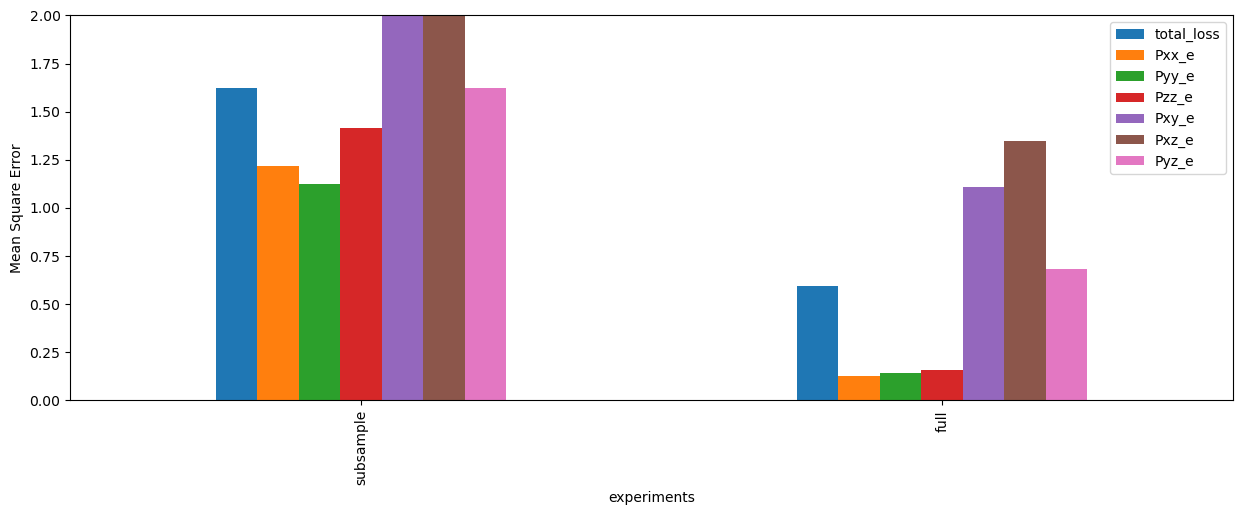

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
selected_columns = loss2.columns[~loss2.columns.str.endswith('_r2')]
selected_data = loss2[selected_columns]
columns = selected_data.columns[loss2.columns.get_loc('total_loss'):]

x = list(loss2['work_dir'])
df = pd.DataFrame({key: value for key, value in zip(columns, loss2[columns].values.T.tolist())}, index=list(x), 
                  dtype=float)
fig = plt.figure(figsize=(15, 5)) 
df.plot.bar(rot=90, ax=fig.gca())
plt.ylim([0,2])
plt.ylabel('Mean Square Error')
plt.xlabel('experiments')

Comparing $r^2$ metric

Text(0.5, 0, 'experiments')

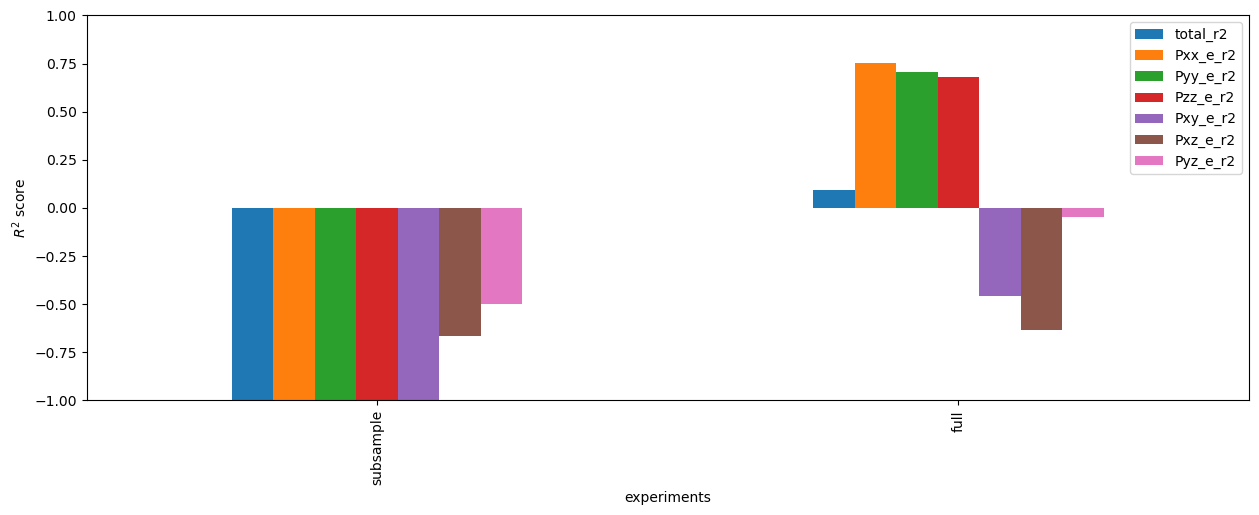

In [35]:
columns_r2 = loss2.columns[loss2.columns.str.endswith('_r2')]
#selected_data_r2 = loss2[selected_columns_r2]
#columns_r2 = selected_data_r2.columns[loss2.columns.get_loc('total_r2'):]
x = list(loss2['work_dir'])

df = pd.DataFrame({key: value for key, value in zip(columns_r2, loss2[columns_r2].values.T.tolist())}, index=list(x), 
                  dtype=float)
fig = plt.figure(figsize=(15, 5)) 
df.plot.bar(rot=90, ax=fig.gca())
plt.ylim([-1,1])
plt.ylabel(r'$R^2$ score')
plt.xlabel('experiments')

# Reloading the trainer

Suppose the training has been performed and you would like to reload the trainer without initializing everything from scratch. 

The following can be run without the need of running any of the previous lines in this notebook assuming that the models already exist (the notebook has already been run once). In fact at this point you can re-load the notebook emptying the RAM.

When providing work directory to the trainer only, it will automatically check if there is a configuration file existing. If there is a configuration file, it will load the trainer with the same parameters as before.

In [2]:
import sys
sys.path.append('../')
import src.trainers as tr
work_dir = '/lustre1/project/stg_00032/georgem/closure/models/dev/dev16/' 
trainer = tr.Trainer(work_dir=work_dir)
trainer.load_run(f'./nosubsample') # load the run which is in the parent directory (runs are always defined relative to the work_dir)

INFO:src.trainers: 
INFO:src.trainers:========Logging to /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//training.log on level 20===========
INFO:src.trainers:host: r25i13n04
INFO:src.trainers: 
INFO:src.datasets: This is train set
INFO:src.datasets:Datasplit performed according to /lustre1/project/stg_00032/share_dir/brecht/sampling/turbulence/train.csv
INFO:src.datasets:Features shape: (1048576, 10), Targets shape: (1048576, 6)
INFO:src.datasets:Loaded self.features_mean, self.features_std from /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//X.pkl
INFO:src.datasets:Normalization applied to features
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Prescaling <ufunc 'log'> applied to targets
INFO:src.datasets:Loaded self.targets_mean, self.targets_std from /lustre1/project/stg_00032/georgem/closure/models/dev/dev16//y.pkl
INFO:src.datasets:Normalization applied to targ

Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

Initializing MLP model.


INFO:src.models:Initializing MLP model.


Optimization criterion MSELoss()


INFO:src.models:Optimization criterion MSELoss()
INFO:src.trainers:Successfully parsed the MLP class
INFO:src.trainers:Creating object: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)
  warnings.warn(msg)

INFO:src.trainers:self.model.device = device(type='cpu')
INFO:src.trainers:Code version git hash: 9e40886ad2550a5f2ab3790b988f6ceaf65bb21d
INFO:src.datasets:ChannelDataLoader.feature_channels: None
INFO:src.datasets:ChannelDataLoader.target_channels: None
INFO:src.datasets:1048576, len(dataset.targets) = 1048576 samples before subsampling
INFO:src.datasets: le

We can verify that we have the right model by running the same code as before:

The function pred_ground_targets is deprecated. Use transform_targets instead.
Total loss 0.594347357749939
Loss for channel 0:  Pxx_e, loss = 0.12743356823921204
Loss for channel 1:  Pyy_e, loss = 0.142177551984787
Loss for channel 2:  Pzz_e, loss = 0.1560910940170288
Loss for channel 3:  Pxy_e, loss = 1.1100741624832153
Loss for channel 4:  Pxz_e, loss = 1.3478821516036987
Loss for channel 5:  Pyz_e, loss = 0.6824254393577576
The function pred_ground_targets is deprecated. Use graph_pred_targets instead.
invfunc = <ufunc 'exp'>


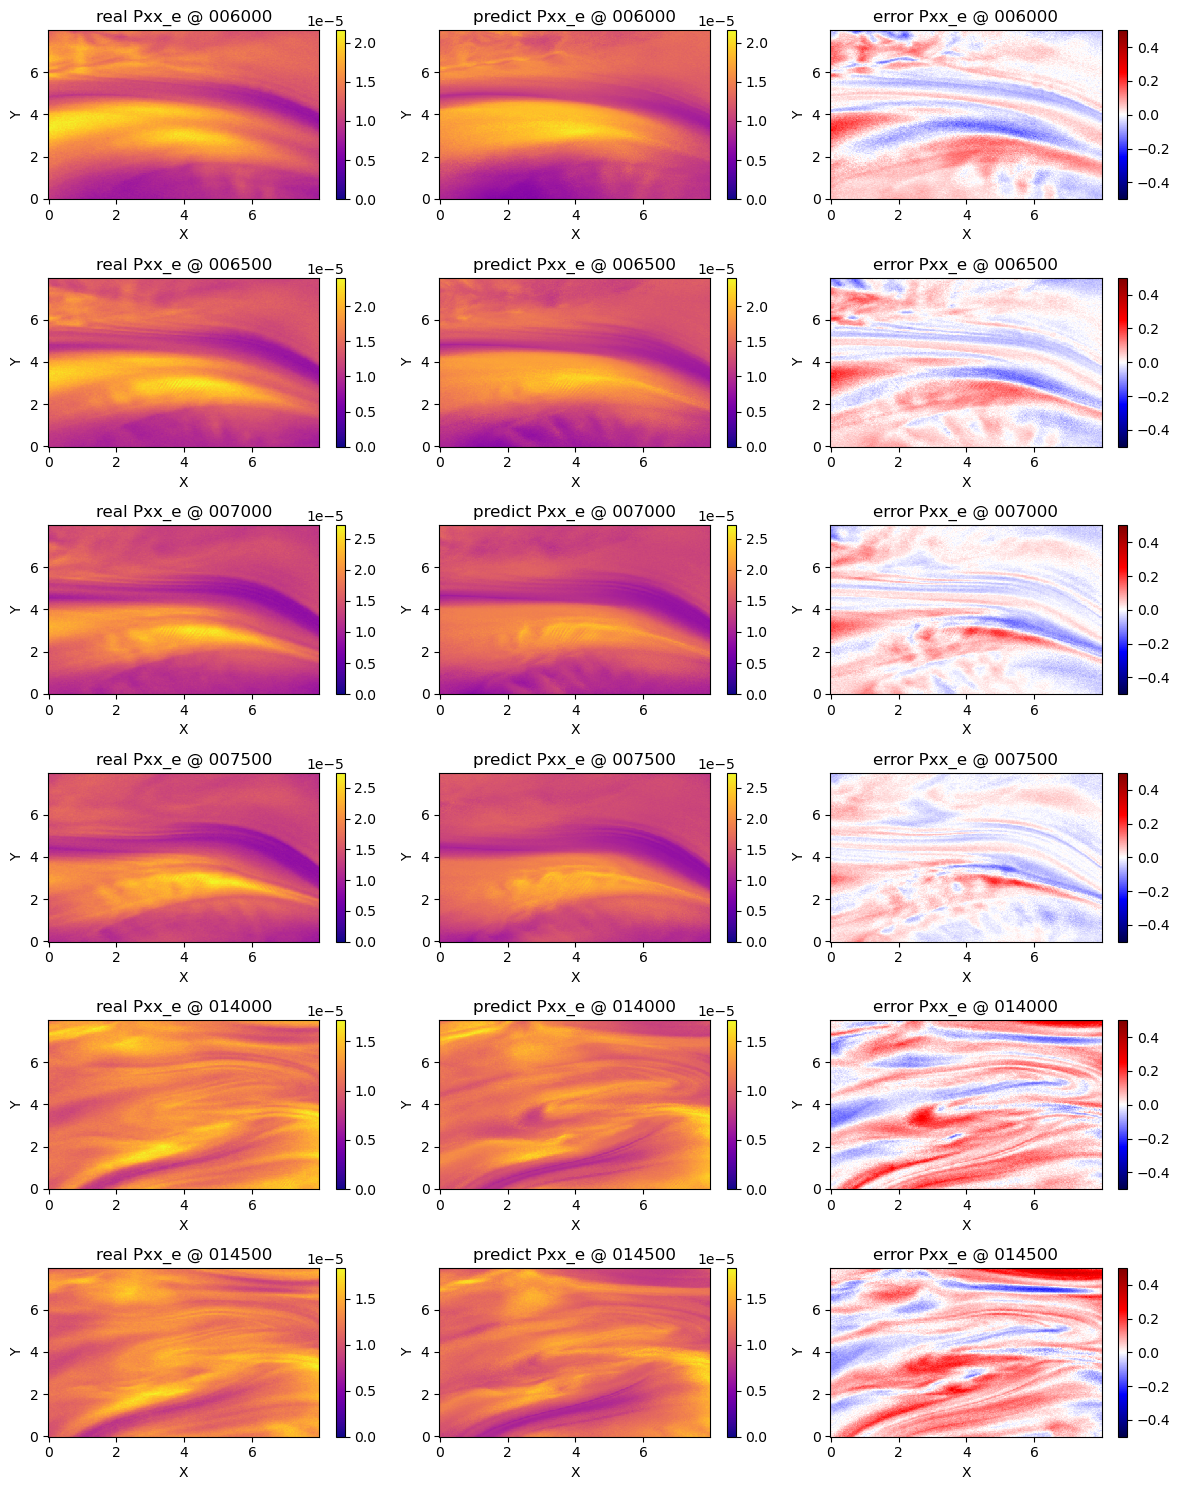

In [4]:
prediction, ground_truth, list_of_target_indices = tr.ut.pred_ground_targets(trainer)
tr.ut.plot_pred_targets(trainer, 'Pxx_e', prediction, ground_truth, list_of_target_indices, figsize=(12,15))
